In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import imaginglss

In [146]:
decals = imaginglss.DECALS('/global/homes/y/yfeng1/m779/yfeng1/imaginglss/dr2.conf.py')

In [6]:
import h5py

In [7]:
# doesn't matter which random we use.
RAN = h5py.File('/global/homes/y/yfeng1/source/imaginglss/nersc/ELG-RANDOM.hdf5', 'r')

In [8]:
print RAN.keys()

[u'COMPLETENESS', u'DEC', u'INTRINSIC_NOISELEVEL', u'RA', u'TYCHO_VETO', u'_HEADER']


In [9]:
from imaginglss.model import product as dataproduct

In [128]:
noise = RAN['INTRINSIC_NOISELEVEL'][:]
mask  = RAN['TYCHO_VETO']['BOSS_DR9'][:]
noiser = noise[~mask]

In [225]:
def brighten(base, confidence={'g':5, 'r':5, 'z':3}):
    
    RA = RAN['RA'][:]
    DEC = RAN['DEC'][:]
    delta = []
    for band in 'rgz':
        noise = RAN['INTRINSIC_NOISELEVEL'][:, dataproduct.bands[band]]
        lim = base[band]
        depth = 22.5 - 2.5 * log10(confidence[band] * noise)
        # This filters inf points automatically
        delta.append(lim - depth)
    # delta > lim - dep
    # dep > lim - delta
    delta = numpy.array(delta).max(axis=0)
    delta = 10 ** ((- delta) / 2.5)
    
    fig = figure(figsize=(8, 8))

    ax = fig.add_subplot(111, projection='aea')
    w, N = mpl_aea.histogrammap(RA, DEC, delta, nside=128) # range=((320, 360), (-2, 2)))
    w = w / N
    w =  - 2.5 * log10(w)
    _ = ax.mapshow(w, ~isinf(w) & ~isnan(w), alpha=1, antialiaseds=False, vmin=0, vmax=1)
    ax.set_title(
        '\n'.join([
        '%d sigma %s depth > %g - $\Delta$' % (confidence[band], band, base[band])
        for band in 'grz'        
        ]))
    ax.set_xlim(100, 400)
    ax.set_ylim(-10, 40)
    ax.set_parallels(-20, 20)
    #ax.set_xlim(320, 360)
    #ax.set_ylim(-2, 2)
    colorbar()
    ax.grid()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


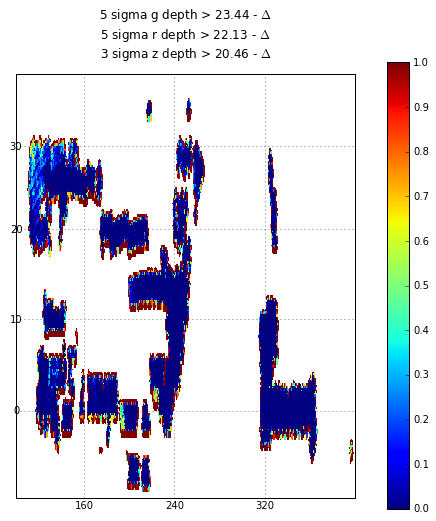

In [226]:
#LSS_LRG
brighten(dict(z=20.46, g=20.46+2.98,r=20.46+1.67))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


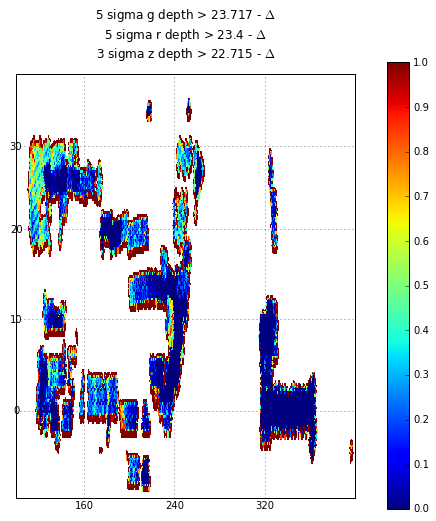

In [227]:
#LSS_ELG
brighten(dict(z=23.4-0.685, g=23.4+0.317,r=23.4))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


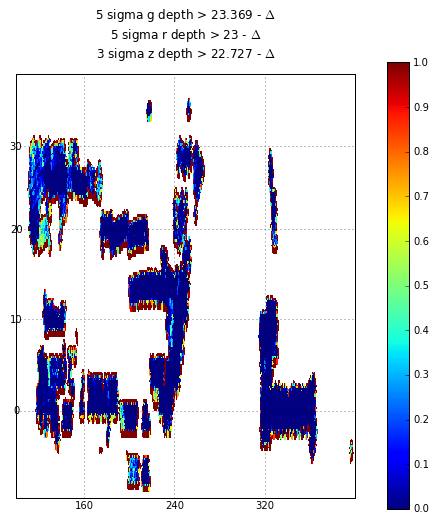

In [228]:
#LSS_QSO
brighten(dict(z=23.0-0.273, g=23.0+0.369,r=23.0))

In [223]:
from imaginglss.utils import mpl_aea
reload(mpl_aea)
def depthperband(band, sigma):
    RA = RAN['RA'][:]
    DEC = RAN['DEC'][:]
    noise = RAN['INTRINSIC_NOISELEVEL'][:, dataproduct.bands[band]]
    
    fig = figure(figsize=(8, 8))
    # IMPORTANT to remove randoms with inf noises
    # they are not, technically in this band, and will bias 
    # the mean noise level estimator
    
    sel = ~isinf(noise)
    RA = RA[sel]
    DEC = DEC[sel]
    noise = noise[sel]
    
    ax = fig.add_subplot(111, projection='aea')
    w, N = mpl_aea.histogrammap(RA, DEC, noise, nside=128) # range=((320, 360), (-2, 2)))
    w = w / N
    w = 22.5 - 2.5 * log10(sigma * w)
    mask = ~isnan(w)
    vmin = percentile(w[mask], 5)
    vmax = percentile(w[mask], 95)
    _ = ax.mapshow(w, mask, alpha=1, vmax=vmax, vmin=vmin, shading='flat', antialiaseds=False)

    ax.set_xlim(100, 400)
    ax.set_ylim(-10, 40)
    ax.set_parallels(-20, 20)
    #ax.set_xlim(320, 360)
    #ax.set_ylim(-2, 2)
    colorbar()
    grid()
    ax.set_title("%g sigma %s depth " % (sigma, band))

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide


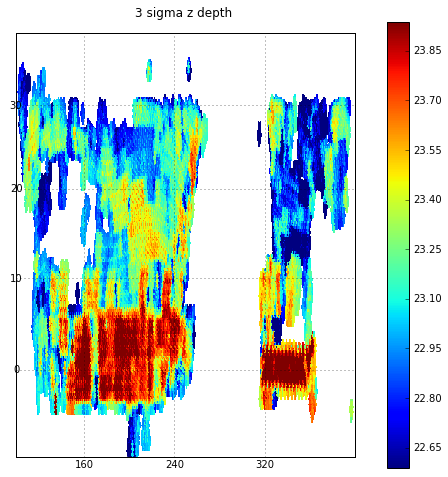

In [224]:
depthperband('z', 3)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide


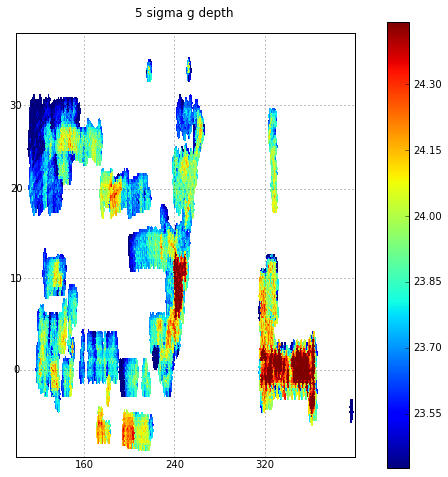

In [203]:
depthperband('g', 5)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide


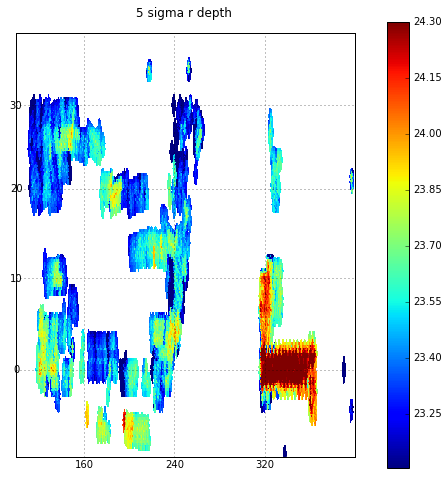

In [204]:
depthperband('r', 5)

In [11]:
print 1.0 * len(noiser) / len(noise)

0.968768857635


In [12]:
def good_fraction(noise, maglims):
    mask = True
    for band in maglims.keys():
        iband = dataproduct.bands[band]
        maglim, sigma = maglims[band]
        nlb = noise[:, iband]
        maglimnoise = 10 ** ((22.5 - maglim) / 2.5)
        mask &= (nlb < maglimnoise / sigma)
    return 1.0 * mask.sum() / len(mask)
        

In [126]:
def ToMag(flux):
    return 22.5 - log10(flux) * 2.5

In [14]:
comp = RAN['COMPLETENESS'][:]

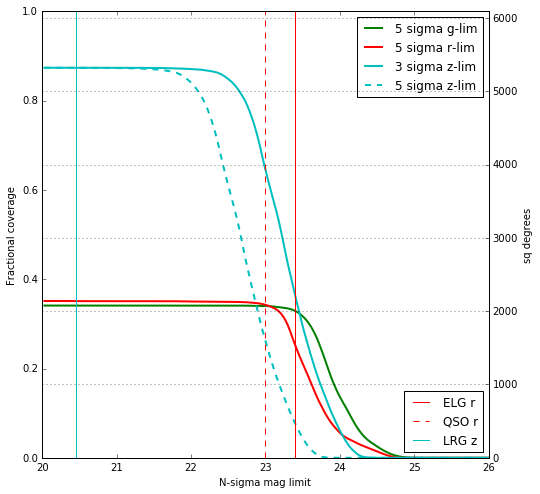

In [147]:

def bandstat(ax, b, sigma, **kwargs):

    mag = ToMag(sigma * noise[:, dataproduct.bands[b]])
   
    vmin = 20
    vmax = 26
    h, bins = histogram(mag, range=(vmin, vmax), bins=200)
    ax.plot(bins[1:], 1.0 * h[::-1].cumsum()[::-1] / len(mag), label='%d sigma %s-lim' % (sigma, b), **kwargs)


fig = figure(figsize=(8, 8))
ax = fig.add_subplot(111)
bandstat(ax, 'g', 5, lw=2, color='g')  
bandstat(ax, 'r', 5, lw=2, color='r') 
bandstat(ax, 'z', 3, lw=2, color='c')
bandstat(ax, 'z', 5, lw=2, color='c', ls='--')

ax.set_xlabel('N-sigma mag limit')
ax.set_ylabel('Fractional coverage')
ax.set_ylim(0, 1.0)
ax.legend(loc='upper right')
twin=ax.twinx()
twin.set_ylim(0, decals.datarelease.footprint.area)
twin.set_ylabel('sq degrees')
twin.axvline(23.4, label='ELG r', color='r')
twin.axvline(23.0, label='QSO r', ls='--', color='r')
twin.axvline(20.46, label='LRG z', color='c')
#twin.axvline(19.5, label='BGS r', color='b')
twin.legend(loc='lower right')
#twin.axhline(comp.sum() / len(comp) * decals.datarelease.footprint.area, label='ELG total area')
twin.grid()

In [16]:
print good_fraction(noise, dict(r={19.5, 5}))

0.351329357026


In [17]:
print good_fraction(noise, dict(z={20.00, 5}))

0.873784563583


In [18]:
print good_fraction(noise, dict(z={20.00, 3}))

0.873784563583


In [19]:
print good_fraction(noise, dict(z={20.36, 5}))

0.873784563583


In [20]:
print good_fraction(noise, dict(z={20.56, 5}))

0.873762269335


In [21]:
from imaginglss.analysis import targetselection

In [22]:
targetselection.ELG.bands

'rgz'

In [23]:
print decals.datarelease.footprint.area

6089.79353207


In [97]:
def mediancolor(objs, magband, colors):
    fluxes = objs['INTRINSIC_FLUX'][:]
    noises = objs['INTRINSIC_NOISELEVEL'][:]
    m = {}
    mask = True
    for band in 'grz':
        ib = dataproduct.bands[band]
        f = fluxes[:, ib]
        n = noises[:, ib]
        c = f / n
        mask &= c > 20
    for band in 'grz':
        ib = dataproduct.bands[band]
        f = fluxes[:, ib][mask]
        n = noises[:, ib][mask]
        m[band] = 22.5 - 2.5 * log10(f)
    figure(figsize=(9, 3))
    for i, b1 in enumerate(colors):
        ax = subplot(1, len(colors), i + 1)
        c = m[b1] - m[magband]
        median = numpy.median(c)
        std = numpy.std(c)
        _ = hist(c, bins=100, range=(median - std * 2, median+std *2))
        xlabel('%s-%s median=%g' %(b1, magband, median))
    

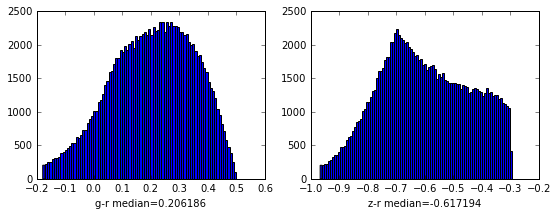

In [98]:
CDR_ELG = h5py.File('/global/homes/y/yfeng1/source/imaginglss/nersc/CDR_ELG.hdf5', 'r')
mediancolor(CDR_ELG, 'r', 'gz')

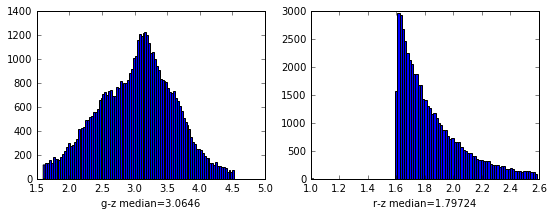

In [99]:
CDR_LRG = h5py.File('/global/homes/y/yfeng1/source/imaginglss/nersc/CDR_LRG.hdf5', 'r')
mediancolor(CDR_LRG, 'z', 'gr')

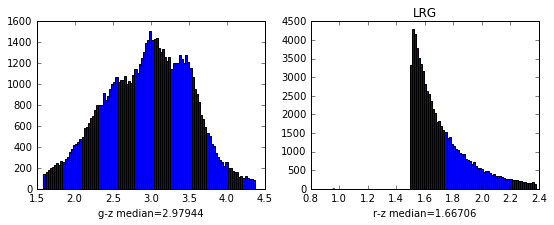

In [148]:
FDR_LRG = h5py.File('/global/homes/y/yfeng1/source/imaginglss/nersc/LRG.hdf5', 'r')
mediancolor(FDR_LRG, 'z', 'gr')
title('LRG')

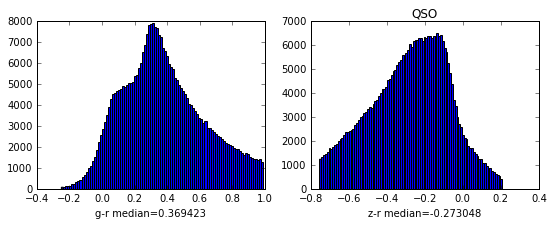

In [150]:
FDR_QSO = h5py.File('/global/homes/y/yfeng1/source/imaginglss/nersc/QSO.hdf5', 'r')
mediancolor(FDR_QSO, 'r', 'gz')
title('QSO')

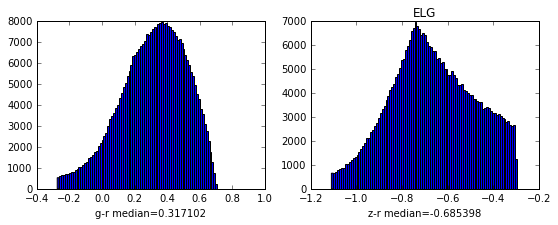

In [149]:
FDR_ELG = h5py.File('/global/homes/y/yfeng1/source/imaginglss/nersc/ELG.hdf5', 'r')
mediancolor(FDR_ELG, 'r', 'gz')
title('ELG')